In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import sys
import random
sys.path.append('../src/')
from random_graph import RandGraph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Model

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

c:\users\girardotm\appdata\local\continuum\anaconda2\envs\graph_ml_problems\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Input is a vector of nodes' congestion  in the current state. Output is the action vector.

In [4]:
state_size = 10
action_size = 10

In [294]:
model = Sequential()
model.add(Dense(32, input_dim=state_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(action_size, activation='softmax'))

In [295]:
model.compile(loss='mse', optimizer='adam')

In [296]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________


## Network

In [7]:
g = RandGraph(actors=100, moving=5, n_core_nodes=10)

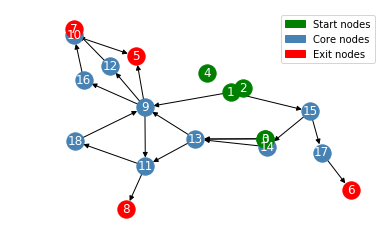

In [8]:
g.plot()

In [44]:
state, reward = g.action()

In [45]:
# nodes congestion
state

array([[0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [46]:
reward

20.0

## Action vector

In [66]:
model.predict(state) > 0.1

array([[ True,  True,  True,  True, False, False,  True, False,  True,
        False]])

In [70]:
action_vector = model.predict(state) > 0.1

In [74]:
next_act = np.where(action_vector==True)[1] + min(g.core_nodes)

In [77]:
list(next_act)

[9, 10, 11, 12, 15, 17]

In [179]:
epsilon = 0.5
def act(state):
    if np.random.rand() <= epsilon:
        # random action
#         print('random')
        k = random.randrange(0,len(g.core_nodes))
        return random.sample(g.core_nodes, k)
    else:
        # predicted action
#         print('predicted')
        action_vector = model.predict(state) > 0.5
        next_act = np.where(action_vector == True)[1] + min(g.core_nodes)
        return list(next_act)

In [188]:
act(state)

random


[10, 16, 18, 15, 17]

## get next state and reward

In [78]:
next_state, reward = g.action(list(next_act))

In [79]:
next_state

array([[0.25, 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [80]:
reward

-6.666666666666666

## Deep Q-learning with experience replay

Initialize replay memory $ \mathcal D $ to capacity $\mathrm N $
Initialize action-value function $\mathcal Q$ with random weights

$\quad$ **for** $episode = 1, M $ **do**   
$\quad$ Initialize sequence $ s_1 = \{x_1\}$ and preprocessed sequenced $ \phi_1 = \phi(s_1)$  
$\quad$ $\quad$ **for** $ t = 1, T $ **do**  
$\quad$ $\quad$ $\quad$ With probability $\epsilon$ to select a random action $ a_t $ or predicted action $ a_t = max_a Q^*(\phi(s_t),a; \theta) $  
$\quad$ $\quad$ $\quad$ Execute action $a_t$ and observe reward $r_t$ and state $x_{t+1}$  
$\quad$ $\quad$ $\quad$ Set $s_{t+1} = s_t, a_t, x_{t+1}$  and preprocess $\phi_{t+1} = \phi(s_{t+1})$  
$\quad$ $\quad$ $\quad$ Store transition $(\phi_t, a_t, r_t, \phi_{t+1}) \,\, in \,\, \mathcal D $  
$\quad$ $\quad$ $\quad$ Sample random minibatch transitions $(\phi_j, a_j, r_j, \phi_{j+1}$ from $\mathcal D$  
$\quad$ $\quad$ $\quad$ Set $ y_i = \bigg\{^{r_j}_{r_j + \gamma max_{a'}Q(\phi_{j+1}, a'; \theta)} $ for terminal or non terminal $\phi_{j+1}$, respectively  
$\quad$ $\quad$ $\quad$ Perform gradient descent step on $(y_i - Q(\phi_j, a_j; \theta))^2 $  
$\quad$ $\quad$ **end for**  
$\quad$ **end for**  

$\phi$ is a function producing a fixed length representation of histories.  
$s_t$ is the finite sequence of observation and actions $ x_1, a_1, x_2, \ldots , a_{t-1}, x_t $ at time $t$  
$Q^*(s,a)$ is the maximum expected return achievable by following any strategy after some sequence $s$ and action $a$
$$ Q^*(s,a) = max_\pi \mathbb E \left[R_t \,\rvert\, s_t = s, a_t = a, \pi \right] $$  
where $\pi$ is the policy mapping sequences to actions.  


## Model $Q(\theta)$

`input` = $s_t$  
`output` = $a_t$  


## Define action space

In [152]:
# for 10 nodes
core_nodes = 10
# how many combinations ?
action_space = core_nodes*(core_nodes - 1)


90

In [167]:
from itertools import product

In [171]:
action_space = list(product([0,1], repeat=10))
len(action_space)

1024

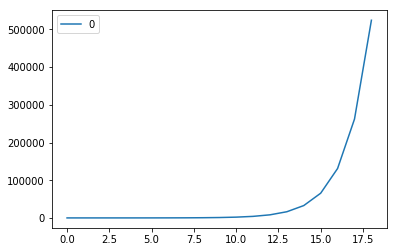

In [179]:
pd.DataFrame([len(list(product([0,1], repeat=n))) for n in range(1,20)]).plot()
plt.show()

The action space is too large when we increase the number of controllable nodes. We will limit ourself to one node per action.

In [193]:
# If we choose to block one node at a time
output_val = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.2,0.1,0.3])

In [194]:
# We choose the node with the max Q value
np.argmax(output_val)

6

In [74]:
# Choose k nodes with max proba
k = 3
np.argpartition(output_val, -k)[-k:]

array([4, 5, 6], dtype=int64)

In [75]:
# Choose threshold for action
threshold = 0.5
np.where(output_val > threshold)[0]

array([5, 6], dtype=int64)

In [76]:
epsilon = 0.5

In [300]:
def act(state, action_size):
    if np.random.rand() <= epsilon:
#         print('random')
        return np.array([[np.random.rand() for _ in range(action_size)]])
    else:
#         print('model')
        return model.predict(state)

In [301]:
act(np.zeros((1,10)), core_nodes)

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)

## Env interaction

In [114]:
g = RandGraph(actors=100, moving=5, n_core_nodes=10)

In [128]:
next_state, reward = g.action(act_val)

In [129]:
next_state

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.        , 0.2       , 0.        , 0.        ]])

In [130]:
reward

27.27272727272727

## Memory $\mathcal D$

In [227]:
state = np.array([[0.,0.,0.0,0.,0.0,.0,.0,0.,0.,0.]])

In [228]:
# each transition is stored in D

D = []
D.append({'state':state, 'action':act_val, 'reward':reward, 'next_state':next_state})

In [229]:
D

[{'state': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  'action': [8],
  'reward': 27.27272727272727,
  'next_state': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.16666667, 0.        , 0.2       , 0.        , 0.        ]])}]

In [230]:
D[0]['reward']

27.27272727272727

In [231]:
# replay
batch_size = 1
batch = random.sample(D, batch_size)
batch

[{'state': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
  'action': [8],
  'reward': 27.27272727272727,
  'next_state': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.16666667, 0.        , 0.2       , 0.        , 0.        ]])}]

## Set target

In [232]:
# discount
gamma = 0.95

In [234]:
for b in batch:
    target = b['reward'] + gamma * np.amax(model.predict(b['next_state']))
    target_f = model.predict(b['state'].reshape((1,10)))
    target_f[0][b['action']] = target
    model.fit(b['state'], target_f, epochs=1, verbose=0)

In [235]:
target_f

array([[ 0.1     ,  0.1     ,  0.1     ,  0.1     ,  0.1     ,  0.1     ,
         0.1     ,  0.1     , 27.371435,  0.1     ]], dtype=float32)

## Training

In [406]:
# initial state 0.0
state = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).reshape((1,10))
# memory
D = []

In [407]:
g = RandGraph(actors=10000, moving=5, n_core_nodes=10)

In [426]:
for time_t in range(100):
    act_val  = act(state, core_nodes)
    blocked_node = [g.core_nodes[np.argmax(act_val)]]
    # env interaction
    next_state, reward = g.action(blocked_node)
    next_state = np.reshape(next_state, (1,core_nodes))
    # stop condition
    if np.isinf(reward) and not np.isnan(reward):
        break
    # remember
    D.append({'state':state, 'action':act_val, 'reward':reward, 'next_state':next_state})
    # move to next step
    state = next_state

In [427]:
len(D)

100

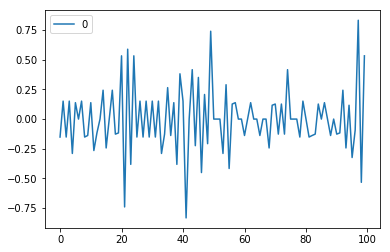

In [428]:
pd.DataFrame([n['reward'] for n in D]).plot()
plt.show()

In [429]:
sum([n['reward'] for n in D])

0.0

## Replay

In [430]:
batch_size = 8
minibatch = random.sample(D, batch_size)

In [431]:
for b in minibatch:
    target = reward + gamma * np.amax(model.predict(b['next_state']))
    target_f = model.predict(b['state'].reshape((1,10)))
    target_f[0][np.argmax(b['action'])] = target
    model.fit(b['state'], target_f, epochs=1, verbose=0)

In [432]:
target_f

array([[0.70267147, 0.07556163, 0.0972218 , 0.09671499, 0.12835136,
        0.17825064, 0.12823045, 0.0917884 , 0.08032601, 0.07278293]],
      dtype=float32)

In [433]:
state

array([[0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

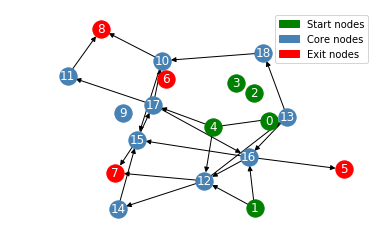

In [425]:
g.plot()

## Setup simple graph

In [236]:
g = RandGraph(actors=1000,graph_type='simple')

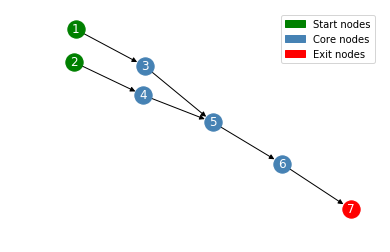

In [237]:
g.plot()

In [238]:
g.graph.nodes(data=True)

NodeDataView({1: {'actors': None}, 2: {'actors': None}, 7: {'actors': None}, 3: {'capacity': 7, 'actors': None}, 4: {'capacity': 6, 'actors': None}, 5: {'capacity': 2, 'actors': None}, 6: {'capacity': 2, 'actors': None}})

In [192]:
state_size = len(g.core_nodes)
action_size = len(g.core_nodes)
epsilon = 0.5
gamma = 0.95

In [193]:
model = Sequential()
model.add(Dense(32, input_dim=state_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(action_size, activation='softmax'))
model.compile(loss='mse', optimizer='adam')

In [194]:
# initial state 0.0
state = np.array([0.,0.,0.,0.]).reshape((1,4))
# memory
D = []

In [195]:
def act(state, action_size):
    if np.random.rand() <= epsilon:
        return np.array([[np.random.rand() for _ in range(action_size)]])
    else:
        return model.predict(state)

In [196]:
for time_t in range(100):
    act_val  = act(state, state_size)
    blocked_node = [g.core_nodes[n] for n in np.where(act_val > 0.5)[0]]
    # env interaction
    next_state, reward = g.action(blocked_node)
    next_state = np.reshape(next_state, (1,state_size))
    # stop condition
    if np.isinf(reward) and not np.isnan(reward):
        break
    # remember
    D.append({'state':state, 'action':act_val, 'reward':reward, 'next_state':next_state})
    # move to next step
    state = next_state

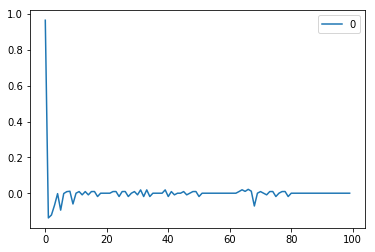

In [197]:
pd.DataFrame([n['reward'] for n in D]).plot()
plt.show()

In [198]:
batch_size = 8
minibatch = random.sample(D, batch_size)

In [199]:
for b in minibatch:
    target = reward + gamma * np.amax(model.predict(b['next_state']))
    target_f = model.predict(b['state'].reshape((1,state_size)))
    target_f[0][np.argmax(b['action'])] = target
    model.fit(b['state'], target_f, epochs=1, verbose=0)

In [200]:
sum([n['reward'] for n in D])

0.5

In [201]:
D[-6:]

[{'state': array([[1., 1., 1., 1.]]),
  'action': array([[0.23123978, 0.35251465, 0.25076485, 0.16548066]], dtype=float32),
  'reward': 0.0,
  'next_state': array([[1., 1., 1., 1.]])},
 {'state': array([[1., 1., 1., 1.]]),
  'action': array([[0.74790238, 0.41739594, 0.13907554, 0.04349214]]),
  'reward': 0.0,
  'next_state': array([[1., 1., 1., 1.]])},
 {'state': array([[1., 1., 1., 1.]]),
  'action': array([[0.23123978, 0.35251465, 0.25076485, 0.16548066]], dtype=float32),
  'reward': 0.0,
  'next_state': array([[1., 1., 1., 1.]])},
 {'state': array([[1., 1., 1., 1.]]),
  'action': array([[0.23123978, 0.35251465, 0.25076485, 0.16548066]], dtype=float32),
  'reward': 0.0,
  'next_state': array([[1., 1., 1., 1.]])},
 {'state': array([[1., 1., 1., 1.]]),
  'action': array([[0.23123978, 0.35251465, 0.25076485, 0.16548066]], dtype=float32),
  'reward': 0.0,
  'next_state': array([[1., 1., 1., 1.]])},
 {'state': array([[1., 1., 1., 1.]]),
  'action': array([[0.07357617, 0.15692529, 0.189696

In [182]:
target_f

array([[0.22611351, 0.23594446, 0.22232471, 0.28225005]], dtype=float32)

## Bloking a combination of nodes

In [202]:
from itertools import combinations

In [232]:
comb = []
for i in range(1,len(g.core_nodes)+1):
    comb.extend(list(combinations(g.core_nodes,i)))

In [233]:
comb

[(3,),
 (4,),
 (5,),
 (6,),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6),
 (3, 4, 5),
 (3, 4, 6),
 (3, 5, 6),
 (4, 5, 6),
 (3, 4, 5, 6)]

In [234]:
state_size = len(g.core_nodes)
action_size = len(comb)
epsilon = 0.5
gamma = 0.95

In [235]:
model = Sequential()
model.add(Dense(32, input_dim=state_size, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(action_size, activation='softmax'))
model.compile(loss='mse', optimizer='adam')

In [239]:
# initial state 0.0
state = np.array([0.,0.,0.,0.]).reshape((1,4))
# memory
D = []

In [247]:
for time_t in range(100):
    act_val  = act(state, action_size)
    comb_nb = np.argmax(act_val)
    blocked_node = comb[comb_nb]
    # env interaction
    next_state, reward = g.action(list(blocked_node))
    next_state = np.reshape(next_state, (1,state_size))
    # stop condition
    if np.isinf(reward) and not np.isnan(reward):
        break
    # remember
    D.append({'state':state, 'action':act_val, 'reward':reward, 'next_state':next_state})
    # move to next step
    state = next_state

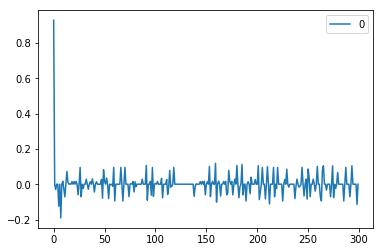

In [248]:
pd.DataFrame([n['reward'] for n in D]).plot()
plt.show()

In [249]:
batch_size = 8
minibatch = random.sample(D, batch_size)
for b in minibatch:
    target = reward + gamma * np.amax(model.predict(b['next_state']))
    target_f = model.predict(b['state'].reshape((1,state_size)))
    target_f[0][np.argmax(b['action'])] = target
    model.fit(b['state'], target_f, epochs=1, verbose=0)

In [250]:
D[-1]

{'state': array([[1.        , 0.83333333, 1.        , 0.        ]]),
 'action': array([[0.65037094, 0.70401949, 0.34387382, 0.68786397, 0.33967549,
         0.25485296, 0.33396321, 0.53842843, 0.73766485, 0.20506263,
         0.36185844, 0.99320726, 0.19670876, 0.1567678 , 0.36863486]]),
 'reward': 0.0,
 'next_state': array([[1.        , 0.83333333, 1.        , 0.        ]])}

In [252]:
comb[np.argmax(D[-1]['action'])]

(3, 4, 6)

## Manual experimentation

In [340]:
g = RandGraph(actors=1000,graph_type='simple', moving=1)

In [341]:
g.graph.nodes(data=True)

NodeDataView({1: {'actors': None}, 2: {'actors': None}, 7: {'actors': None}, 3: {'capacity': 7, 'actors': None}, 4: {'capacity': 6, 'actors': None}, 5: {'capacity': 2, 'actors': None}, 6: {'capacity': 2, 'actors': None}})

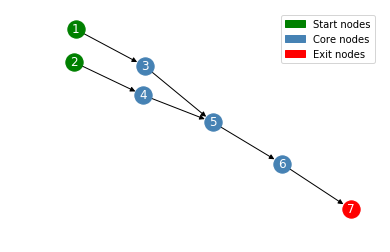

In [342]:
g.plot()

In [343]:
prev_output = 0
def get_reward(g, state, prev_output):
    out = sum([len(g.graph.node[n]['actors']) for n in g.exit_nodes if g.graph.node[n]['actors']])
    congestion = 1 - np.mean(state)
    reward = (out - prev_output) * congestion
    prev_output = out
    return reward, prev_output

In [344]:
blocked_nodes = []
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.         0.16666667 0.         0.        ]]
0.0


NodeDataView({1: {'actors': None}, 2: {'actors': [b'196e6734']}, 7: {'actors': None}, 3: {'capacity': 7, 'actors': None}, 4: {'capacity': 6, 'actors': [b'196e6734']}, 5: {'capacity': 2, 'actors': None}, 6: {'capacity': 2, 'actors': None}})

In [345]:
blocked_nodes = [4]
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.14285714 0.         0.5        0.        ]]
0.0


NodeDataView({1: {'actors': [b'fb8838b5']}, 2: {'actors': [b'196e6734', b'fc382ce3']}, 7: {'actors': None}, 3: {'capacity': 7, 'actors': [b'fb8838b5']}, 4: {'capacity': 6, 'actors': []}, 5: {'capacity': 2, 'actors': [b'196e6734']}, 6: {'capacity': 2, 'actors': None}})

The next step, node 5 will recieve another actor, thus we need to block it to avoid saturation

In [346]:
blocked_nodes = [3]
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.         0.16666667 0.5        0.5       ]]
0.0


NodeDataView({1: {'actors': [b'fb8838b5', b'2309d8f8', b'b7a54e95']}, 2: {'actors': [b'196e6734', b'fc382ce3']}, 7: {'actors': None}, 3: {'capacity': 7, 'actors': []}, 4: {'capacity': 6, 'actors': [b'fc382ce3']}, 5: {'capacity': 2, 'actors': [b'fb8838b5']}, 6: {'capacity': 2, 'actors': [b'196e6734']}})

In [347]:
blocked_nodes = [4]
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.42857143 0.         0.5        0.5       ]]
0.6428571428571428


NodeDataView({1: {'actors': [b'fb8838b5', b'2309d8f8', b'b7a54e95', b'223a802a']}, 2: {'actors': [b'196e6734', b'fc382ce3', b'825f4ce9', b'1fd0317b']}, 7: {'actors': [b'196e6734']}, 3: {'capacity': 7, 'actors': [b'2309d8f8', b'b7a54e95', b'223a802a']}, 4: {'capacity': 6, 'actors': []}, 5: {'capacity': 2, 'actors': [b'fc382ce3']}, 6: {'capacity': 2, 'actors': [b'fb8838b5']}})

In [348]:
blocked_nodes = [3,4]
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.14285714 0.         1.         0.5       ]]
0.5892857142857143


NodeDataView({1: {'actors': [b'fb8838b5', b'2309d8f8', b'b7a54e95', b'223a802a', b'3f3bdd50']}, 2: {'actors': [b'196e6734', b'fc382ce3', b'825f4ce9', b'1fd0317b', b'50ae9600', b'23e4109d', b'9e0292cb']}, 7: {'actors': [b'196e6734', b'fb8838b5']}, 3: {'capacity': 7, 'actors': [b'223a802a']}, 4: {'capacity': 6, 'actors': []}, 5: {'capacity': 2, 'actors': [b'2309d8f8', b'b7a54e95']}, 6: {'capacity': 2, 'actors': [b'fc382ce3']}})

The reward should reflect the increase in actors in the output nodes and the low congestion of the core nodes.

In [349]:
blocked_nodes = [3]
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.  1.  0.5 1. ]]
0.375


NodeDataView({1: {'actors': [b'fb8838b5', b'2309d8f8', b'b7a54e95', b'223a802a', b'3f3bdd50', b'4127117d', b'7096243a']}, 2: {'actors': [b'196e6734', b'fc382ce3', b'825f4ce9', b'1fd0317b', b'50ae9600', b'23e4109d', b'9e0292cb', b'e6d92883', b'8541fc6c']}, 7: {'actors': [b'196e6734', b'fb8838b5', b'fc382ce3']}, 3: {'capacity': 7, 'actors': []}, 4: {'capacity': 6, 'actors': [b'825f4ce9', b'1fd0317b', b'50ae9600', b'23e4109d', b'9e0292cb', b'e6d92883']}, 5: {'capacity': 2, 'actors': [b'223a802a']}, 6: {'capacity': 2, 'actors': [b'2309d8f8', b'b7a54e95']}})

In [350]:
blocked_nodes = [3,4]
state, reward = g.action(blocked_nodes)
print(state)
reward, prev_output = get_reward(g,state, prev_output)
print(reward)
g.graph.nodes(data=True)

[[0.         0.66666667 1.         0.5       ]]
0.9166666666666667


NodeDataView({1: {'actors': [b'fb8838b5', b'2309d8f8', b'b7a54e95', b'223a802a', b'3f3bdd50', b'4127117d', b'7096243a', b'7f8acf3f']}, 2: {'actors': [b'196e6734', b'fc382ce3', b'825f4ce9', b'1fd0317b', b'50ae9600', b'23e4109d', b'9e0292cb', b'e6d92883', b'8541fc6c', b'1b9c0dbb', b'57596b91', b'3a831165']}, 7: {'actors': [b'196e6734', b'fb8838b5', b'fc382ce3', b'2309d8f8', b'b7a54e95']}, 3: {'capacity': 7, 'actors': []}, 4: {'capacity': 6, 'actors': [b'50ae9600', b'23e4109d', b'9e0292cb', b'e6d92883']}, 5: {'capacity': 2, 'actors': [b'825f4ce9', b'1fd0317b']}, 6: {'capacity': 2, 'actors': [b'223a802a']}})

In [353]:
manual_collection = [0.0, 0.0, 0.0, 0.6428571428571428, 0.5892857142857143, 0.375, 0.9166666666666667]

In [351]:
# compare to no action
g = RandGraph(actors=1000,graph_type='simple', moving=1)
prev_output = 0
total_rewards = []
for i in range(7):
    state, _ = g.action()
    reward, prev_output = get_reward(g,state, prev_output)
    total_rewards.append(reward)

In [352]:
total_rewards

[0.0,
 0.0,
 0.0,
 0.3392857142857143,
 0.6309523809523809,
 0.48809523809523814,
 0.3333333333333335]

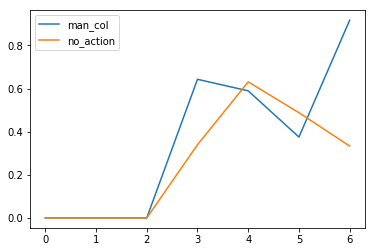

In [354]:
pd.DataFrame({'no_action':total_rewards, 'man_col': manual_collection}).plot()
plt.show()

In [355]:
sum(total_rewards)

1.791666666666667

In [356]:
sum(manual_collection)

2.5238095238095237